In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import json
from collections import Counter

In [3]:
data = []
for line in open('/content/drive/My Drive/data/Electronics_5.json', 'r'):
    data.append(json.loads(line))

In [4]:
reviews = [entry["reviewText"] for entry in data]

In [5]:
reviews = reviews[:50000]


In [6]:
c = Counter()

In [7]:
i = 0
for review in reviews:

  words = review.split()
  for word in words:
    c[word.lower()]+=1

In [8]:
cleaned_reviews = []
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
x = tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
cleaned_reviews = []

In [10]:
for review in reviews:

  words = tokenizer.tokenize(review)
  new_words = []
  for word in words:
    word = word.lower()
    if c[word]>=5 and word not in stop_words:
      new_words.append(word)
  new_review = " ".join(new_words)
  cleaned_reviews.append(new_review)

In [12]:
with open('reviews.txt', 'w') as f:
    for item in cleaned_reviews:
        f.write("%s\n" % item)

In [13]:
with open('/content/drive/My Drive/data/a2/reviews.txt') as file:
    cleaned_reviews = file.readlines()
    cleaned_reviews = [line.rstrip() for line in cleaned_reviews]

In [14]:
len(cleaned_reviews)

50000

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm import tqdm

In [16]:
WINDOWS_SIZE = 2
EMBEDDING_DIM = 10
BATCH_SIZE = 1000
NUM_EPOCH = 5
class Text2DataSet(Dataset):

    def __init__(self, window_size=2):

        self.context_target = []
        self.vocab = set()
        for review in cleaned_reviews:
          words_tokenized = review.split()
          for word in words_tokenized:
            self.vocab.add(word)
          for i in range(window_size, len(words_tokenized)-window_size):
            self.context_target.append(([words_tokenized[i-(j+1)] for j in range(window_size)] +\
                                 [words_tokenized[i+(j+1)] for j in range(window_size)],
                                words_tokenized[i]))

        self.word_to_idx = {word_tuple: idx for idx, word_tuple in enumerate(self.vocab)}
        self.idx_to_word = list(self.word_to_idx.keys())
        self.vocab_size = len(self.vocab)
        self.window_size = window_size

    def __getitem__(self, idx):
        context = torch.tensor([self.word_to_idx[w] for w in self.context_target[idx][0]])
        target = torch.tensor([self.word_to_idx[self.context_target[idx][1]]])
        return context, target

    def __len__(self):
        return len(self.context_target)

In [17]:
data = Text2DataSet()
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim, window_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.window_size = window_size

    def forward(self, inputs):

        embeds = torch.sum(self.embeddings(inputs), dim=1)
        out = self.linear(embeds) # nonlinear + projection
        log_probs = F.log_softmax(out, dim=1) # softmax compute log probability

        return log_probs
      

In [18]:
model = CBOW(len(data.vocab), EMBEDDING_DIM, WINDOWS_SIZE)

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.NLLLoss()
data_loader = DataLoader(data, batch_size=BATCH_SIZE)
cuda_available = torch.cuda.is_available()

In [ ]:
for epoch in range(NUM_EPOCH):
    total_loss = 0
    for context, target in tqdm(data_loader):
        # context: torch.Size([10, 4])
        # target:  torch.Size([10, 1])
        if context.size()[0] != BATCH_SIZE:
            continue

        if cuda_available:
            context = context.cuda()
            target = target.squeeze(1).cuda()
            model = model.cuda()

        model.zero_grad()
        log_probs = model(context)
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


In [21]:
my_words = ['camera','clean','depressed','run','wallet']
from numpy.linalg import norm
all_vec = [[] for i in my_words]

In [22]:
for k,my_word in enumerate(my_words):
  for j,other_word in enumerate(data.vocab):
    vec1 = model.embeddings.weight[data.word_to_idx[my_word]]
    vec2 = model.embeddings.weight[data.word_to_idx[other_word]]
    dist = norm(vec1.cpu().detach().numpy()-vec2.cpu().detach().numpy())
    all_vec[k].append({other_word:dist})
for i,item in enumerate(all_vec):
  all_vec[i] = sorted(all_vec[i], key=lambda x: list(x.values())[0])
final_words = []
for i,item in enumerate(all_vec):
  print(f"For {my_words[i]}:")
  for j in all_vec[i][1:11]:
    word_key = list(j.keys())[0]
    print(word_key)
    final_words.append(word_key)
  print()

For camera:
macro
bag
tripod
step
sensors
everywhere
32mm
gl2
body
rarely

For clean:
nice
wonderful
cool
acceptable
particularly
art
natural
makes
bright
appreciate

For depressed:
clicking
learns
slightest
cranking
squint
grasp
push
manipulate
overcome
pressing

For run:
measuring
determine
manage
runs
single
separate
offline
loosing
requires
efficiently

For wallet:
carrying
fit
fold
holder
unobtrusive
case
stacked
fitted
folds
sling



In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def tsne_plot():
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in final_words:
        tokens.append(model.embeddings.weight[data.word_to_idx[word]].cpu().detach().numpy())
        labels.append(word)
    
    tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

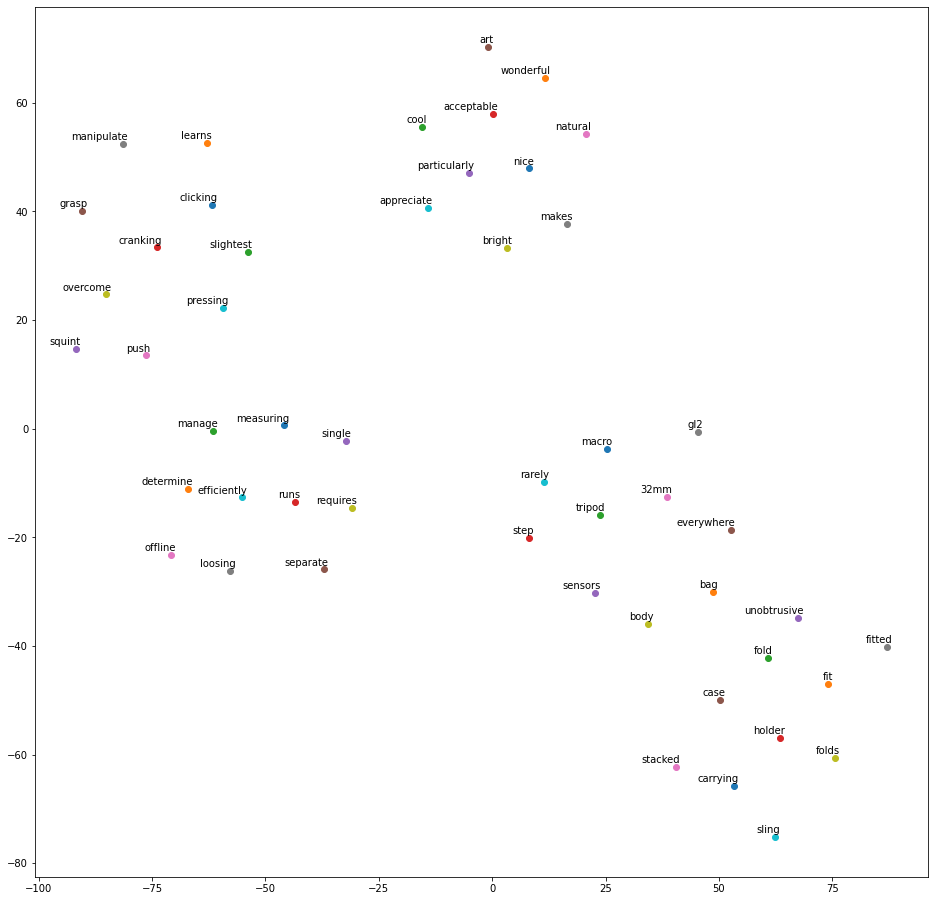

In [24]:
len(final_words)
tsne_plot()